# Spatial model

**Open questions**
* Why do we need `json` ("lightweight data interchange format inspired by JavaScript object literal syntax")? Doesn't seem like this is actively used (same for various other packages)
* `xarray`: "Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays"
* When `stratified=False`, some important parameters (such as `h`) are not loaded (or at least that's what the function information says). This is wrong?
* Why are the matrices found by `polymod.get_interaction_matrices()` not identical to those found in the [SOCRATES](https://lwillem.shinyapps.io/socrates_rshiny/) tool? How is this tool to be interpreted? See [this](https://www.medrxiv.org/content/10.1101/2020.03.03.20030627v2) paper.
* When taking the parameter values with `get_COVID19_SEIRD_parameters(age_stratified=True)`, not all values are being copied from their age-stratified values. Examples:
    * Mortalities for patients in ICU *is* age-stratified
    * Average number of days in cohort when patient will recover *is not* age-stratified. Why not?
* Should we work with the most recent data where possible? E.g. for initial population, almost all arrondissements have higher population now than 9 years ago (2011 census), and this is easily found online.
* Why is the initial population per age in `polymod.get_interaction_matrices()[0]` significantly larger than the sum over all arrondissements in `../../data/interim/census_2011/initN.csv`? Which one should we use? Both are from roughly the same time period, no?
    * Compare e.g. `polymod.get_interaction_matrices()[0]` with `initN_df['[0,10['].sum()`
* In the relative susceptibility taken from the study of Davies, *all* $s$-values are below 1. I would expect the age-weighed average of $s$ to be precisely 1.
    * Why is this not the case?
    * Does that mean that we must not take `pars_dict['s'] = 1` in the case of no age stratification?
* `pars_dict['Nc'] = np.array([11.2])` comes from the average number of contacts, weighed by age. The other matrices do *not* appear to be weighed by age. What do we want?
* The way the code works now, there are about 40M people that will get mildly affected by COVID. This is not possible, as there are only 11M Belgians.
* The simulation sometimes runs into a division by zero (but generally continues running)
* What does the `.sim` attribute do? I cannot find this anywhere.
    * This is inside `base.py` as well!
* I do not understand how the `integrate` function defined in `models.py` is related to the rest of the code, and I also do not understand how `BaseModel` can be an argument of the class in `models.py`. Confusing.
    * Update: `integrate` is part of `base.py`. The search function only works for the part of the code you can see!

**Open tasks**
* Go through the structure of all `data` and `src` modules, in particular `BaseModel`
* Adjust `get_COVID19_SEIRD_parameters` to take and return data needed for spatial extension
    * Now it take data from `/data/interim/census_2011/recurrent_mobility.csv`, which is deprecated
    * Adapt `NIS_name.csv`
    * It would be nice to be able to *choose* the level of stratification
        * Age: take data straight from the full SOCRATES tool (probably not very convenient to implement)
        * Space: choose between artificial, postal code, municipality, arrondissement, province
    * Add additional parameters
        * ag: areas of patches
        * pi: mobility per age (perhaps also add pg: mobility per patch later)
        * sigmag: average household size per patch
        * xi: influence of density on contact (Arenas fixes this to 0.01)
    * Adjust the function description (this is kind of a mess now)
* Find a way to *first* work without age stratification
    * Make a clear distinction between age-stratified case and non-stratified case
    * Make available all non-stratified data, and make sure this is correct: currently the average $m_0$ is set to 0.5, which seems terribly high
* Find a nice way to include $\tau$ and $l$ parameters associated with `ramp_2` in the `get_COVID19_SEIRD_parameters`.
* Find out whether the version without age-stratification works well, or if it is faulty. In the latter case: where does it break down?
* Add newest geography for arrondissement (post-2019)
* Change `read_csv` path to absolute path (relative path takes path relative to place of execution!) in function `read_coordinates_nis()`

## Load packages

In [1]:
import random
import os
import numpy as np
import json
import corner # make beautiful corner plots for demonstrating the parameter distributions
import random
import os

import pandas as pd
import geopandas as gp
import datetime
import scipy
import matplotlib
import matplotlib.colors as colors
import matplotlib.dates as mdates # sophisticated date plotting capabilities
import math
import xarray as xr # labels in the form of dimensions, coordinates and attributes
import emcee # Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (**MCMC**) Ensemble sampler
import matplotlib.pyplot as plt

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import name2nis # New function that translates names to NIS codes
from covid19model.data import google, sciensano, polymod, model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

## Understand current code and data loads

### `COVID19_SEIRD_sto_spatial`

The class `COVID19_SEIRD_sto_spatial` inside `models.py` in which the integration happens, takes the same inputs as `BaseModel`. This is:
1. `states`: dictionary of initial states of all (stratified) compartments. Typically, only the compartments S, E and T (total) are non-zero at the start. The states are matrices with dimensions of the stratification (e.g. 3x4)
2. `parameters`: dictionary of parameters (both stratified and not) that are obtained with `parameters.get_COVID19_SEIRD_parameters()`
3. `compliance`. Set to `None` by default, but we will generally use `ramp_2`
4. `discrete`. Set to `False` by default, but we implement a discrete set now (i.e. `True`)

In [4]:
# When spatial==True, the mobility matrix is added to the parameter dictionary:
# This is only the 43x43 matrix, and contains the old definitions of arrondissements (does not have 58000 yet)
# Read as: fraction of (row) commutes to (column), so the sum of every row should be unity

mobility_df=pd.read_csv('../../data/interim/census_2011/census-2011-updated_row-commutes-to-column_arrondissements.csv', index_col=['NIS'])
NIS=mobility_df.values.astype(float)
# Normalize recurrent mobility matrix
for i in range(NIS.shape[0]):
    NIS[i,:]=NIS[i,:]/sum(NIS[i,:])
NIS

array([[7.82887752e-01, 4.38638179e-02, 2.76247004e-02, ...,
        1.28922010e-04, 1.38780752e-03, 7.07807112e-05],
       [1.85681457e-01, 5.31539685e-01, 3.35513523e-02, ...,
        9.19215132e-05, 1.42124801e-03, 5.65670850e-05],
       [1.24653535e-01, 4.12220914e-02, 6.97745139e-01, ...,
        1.42545654e-04, 1.07701161e-03, 1.05589373e-04],
       ...,
       [5.27698128e-03, 1.97585600e-03, 1.20479025e-03, ...,
        5.28541481e-01, 1.71441652e-01, 1.18310402e-02],
       [5.86311126e-03, 1.91296427e-03, 1.20905967e-03, ...,
        2.98952424e-02, 5.86162064e-01, 7.87545029e-03],
       [6.03638143e-03, 1.95774533e-03, 1.67224080e-03, ...,
        2.85096664e-02, 7.63520679e-02, 4.33477445e-01]])

In [5]:
# Every arrondissement has an initial population (initial number of susceptibles) per age group

# Read CSV as dataframe with the first column (NIS) as index
initN_df=pd.read_csv('../../data/interim/census_2011/initN.csv', index_col=[0])

# Save the population distribution for all arrondissements
initN=initN_df.iloc[:,2:].values
initN_df.head()

# Make sure the shape of the initN is 1x43 rather than just 43
# N_dummy = []
# for i in range(len(initN)):
#     N_dummy.append([initN[i]])
    
# initN = np.asarray(N_dummy)

,name,total,"[0,10[","[10,20[","[20,30[","[30,40[","[40,50[","[50,60[","[60,70[","[70,80[","[80,inf["
NIS-code,,,,,,,,,,,
11000,Arrondissement Antwerpen,1005002.0,116466.0,112965.0,129727.0,131297.0,144626.0,133046.0,102617.0,80576.0,53682.0
12000,Arrondissement Mechelen,327928.0,36304.0,36491.0,38710.0,41832.0,50049.0,45157.0,34414.0,27412.0,17559.0
13000,Arrondissement Turnhout,440337.0,45627.0,48864.0,52869.0,56162.0,70786.0,64688.0,47770.0,35043.0,18528.0
21000,Arrondissement Brussel-Hoofdstad,1136778.0,155502.0,122871.0,177461.0,195891.0,157533.0,124139.0,88540.0,64245.0,50596.0
23000,Arrondissement Halle-Vilvoorde,600350.0,69414.0,73678.0,66625.0,73834.0,92424.0,83928.0,61916.0,48368.0,30163.0


### `get_COVID19_SEIRD_parameters`

The Python code `data/model_parameters.py` contains the important (and only) function `get_COVID19_SEIRD_parameters` which fetches all necessary parameters. Information (note that this is quite a mess):
* Takes two inputs
    * `stratified`: Boolean, choose whether or not there is age stratification
    * `spatial`: Boolean, choose whether or not there is spatial stratification
* Returns the parameter dictionary, as desired as input to `COVID19_SEIRD_sto_spatial(BaseModel)`
* If both `stratified` and `spatial` are true, the parameters are ...
    * `beta` : probability $\beta$ of infection when encountering an infected person
    * `sigma` : length $\sigma$ of the latent period
    * `omega` : length $\omega$ of the pre-symptomatic infectious period
    * `zeta`: effect $\zeta$ of re-susceptibility and seasonality
    * `a` : probability $a$ of an asymptomatic cases
    * `m` : probability $m$ of an initially mild infection (m=1-a): superfluous
    * `da` : duration $d_a$ of the infection in case of asymptomatic
    * `dm` : duration $d_m$ of the infection in case of mild
    * `der` : duration of stay $d_{\text{ER}}$ in emergency room/buffer ward
    * `dc` : average length $d_c$ of a hospital stay when not in ICU
    * `dICU_R` : average length $d_{\text{ICU},R}$ of a hospital stay in ICU in case of recovery
    * `dICU_D`: average length $d_{\text{ICU},D}$ of a hospital stay in ICU in case of death
    * `dhospital` : time $d_\text{hosp}$ before a patient reaches the hospital (*below: age-stratified*)
    * `s`: relative susceptibilities $s_i$ to infection (unique)
    * `a` : probabilities $a_i$ of an asymptomatic case (overwrites $a$ and $m$)
    * `h` : probabilities $h_i$ of hospitalisation for a mild infection
    * `c` : probabilities $c_i$ of hospitalisation in Cohort (non-ICU)
    * `m_C` : mortalities $m_{C,i}$ in Cohort
    * `m_ICU` : mortalities $m_{\text{ICU},i}$ in ICU (*below: spatially stratified*)
    * `NIS`: normalised mobility between NIS codes
* If no age stratification is chosen, the final value in the data column always communicates the weighted average

In [6]:
# Most hospital data is taken from `data/interim/model_parameters/AZMM_UZG_hospital_parameters.csv`,
# which is good but may be updated with Sciensano data at some point.
# Question: why is m_C age-stratified ([:-1]) and e.g. dC_R not ([-1])?

# This hospital data looks as follows
df = pd.read_csv('../../data/interim/model_parameters/AZMM_UZG_hospital_parameters.csv', sep=',',header='infer')
df = df.fillna(0)
print(df)

m_ICU = np.array(df['m0_{ICU}'].values[:-1])
dc_R = np.array(df['dC_R'].values[-1])

print(m_ICU)
print(dc_R)

df

  Unnamed: 0  sample_size         c        m0  m0_{ICU}    m0_{C}        dC  \
0    [0, 10)            2  1.000000  0.000000  0.000000  0.000000  0.000000   
1   [10, 20)            7  1.000000  0.000000  0.000000  0.000000  2.749603   
2   [20, 30)            9  0.800000  0.000000  0.000000  0.000000  5.000000   
3   [30, 40)            9  0.875000  0.000000  0.000000  0.000000  5.659920   
4   [40, 50)           33  0.781250  0.093750  0.142857  0.080000  5.506805   
5   [50, 60)           67  0.741935  0.032258  0.062500  0.021739  6.834737   
6   [60, 70)           62  0.612903  0.064516  0.166667  0.000000  8.991191   
7   [70, 80)           74  0.642857  0.271429  0.440000  0.177778  8.274613   
8  [80, 120)          107  0.882353  0.411765  0.583333  0.366667  8.558533   
9    average          370  0.752874  0.195402  0.279070  0.167939  7.691701   

        dC_R      dC_D       dICU     dICU_R     dICU_D    dICUrec  
0   0.000000  0.000000   0.000000   0.000000   0.000000   0.0

,Unnamed: 0,sample_size,c,m0,m0_{ICU},m0_{C},dC,dC_R,dC_D,dICU,dICU_R,dICU_D,dICUrec
0,"[0, 10)",2,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"[10, 20)",7,1.000000,0.000000,0.000000,0.000000,2.749603,2.749603,0.000000,0.000000,0.000000,0.000000,0.000000
2,"[20, 30)",9,0.800000,0.000000,0.000000,0.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,5.000000
3,"[30, 40)",9,0.875000,0.000000,0.000000,0.000000,5.659920,5.659920,0.000000,12.000000,12.000000,0.000000,10.000000
4,"[40, 50)",33,0.781250,0.093750,0.142857,0.080000,5.506805,5.507397,5.500000,15.029562,14.682059,17.114581,4.857143
5,"[50, 60)",67,0.741935,0.032258,0.062500,0.021739,6.834737,6.955910,1.381944,10.779253,8.200185,49.465275,8.052647
6,"[60, 70)",62,0.612903,0.064516,0.166667,0.000000,8.991191,8.991191,0.000000,8.718547,8.061145,12.005555,3.473119
7,"[70, 80)",74,0.642857,0.271429,0.440000,0.177778,8.274613,8.413382,7.632811,18.803999,13.524305,25.523610,8.767138
8,"[80, 120)",107,0.882353,0.411765,0.583333,0.366667,8.558533,10.082991,5.925378,8.904455,7.615694,9.824999,6.353761
9,average,370,0.752874,0.195402,0.279070,0.167939,7.691701,8.010292,6.113225,12.510158,9.866722,19.339032,6.472335


In [7]:
# Some additional data is taken from `verity_etal.csv` and `davies_etal.csv` in the raw directory
# full Verity data
df = pd.read_csv('../../data/raw/model_parameters/verity_etal.csv', sep=',',header='infer')
print(df)

# h: probability of being hospitalised per age
h = np.array(df.loc[:,'symptomatic_hospitalized'].astype(float).tolist())/100
print(h)

  age_group  symptomatic_hospitalized  hospitalized_ICU     CFR
0       0-9                       0.1               5.0   0.003
1     10-19                       0.3               5.0   0.015
2     20-29                       1.2               5.0   0.060
3     30-39                       3.2               5.0   0.146
4     40-49                       4.9               6.3   0.295
5     50-59                      10.2              12.2   1.250
6     60-69                      16.6              27.4   3.990
7     70-79                      24.3              43.2   8.610
8       80+                      27.3              70.9  13.400
[0.001 0.003 0.012 0.032 0.049 0.102 0.166 0.243 0.273]


In [8]:
# full Davies data
df_asymp = pd.read_csv('../../data/raw/model_parameters/davies_etal.csv', sep=',',header='infer')
print(df_asymp)

# a: probabilty of being asymptomatic per age; s: relative susceptibility per age
a = np.array(df_asymp.loc[:,'fraction asymptomatic'].astype(float).tolist())
s = np.array(df_asymp.loc[:,'relative susceptibility'].astype(float).tolist())
print(a)
print(s)

  age_group  fraction asymptomatic  relative susceptibility
0       0-9                   0.71                     0.40
1     10-19                   0.79                     0.38
2     20-29                   0.73                     0.79
3     30-39                   0.67                     0.86
4     40-49                   0.60                     0.80
5     50-59                   0.51                     0.82
6     60-69                   0.37                     0.88
7     70-79                   0.31                     0.74
8       80+                   0.31                     0.74
[0.71 0.79 0.73 0.67 0.6  0.51 0.37 0.31 0.31]
[0.4  0.38 0.79 0.86 0.8  0.82 0.88 0.74 0.74]


In [9]:
# If there is no age stratification (as we may want to try at first in the simplified spatial model),
# the parameter dictionary takes parameter values from `../../data/raw/model_parameters/non_stratified.csv`
# and updates the parameters dictionary with these

non_strat = pd.read_csv("../../data/raw/model_parameters/non_stratified.csv", sep=',',header='infer')
a = non_strat['a'].values[0]
a
non_strat
# pars_dict.update({key: np.array(value) for key, value in non_strat.to_dict(orient='list').items()})

,a,h,icu,m0
0,0.43,0.2,0.333333,0.5


In [10]:
# Beta is set manually
beta = 0.03492
beta

0.03492

In [11]:
# Remaining parameters

df_other_pars = pd.read_csv('../../data/raw/model_parameters/others.csv', sep=',',header='infer')
df_other_pars

,da,dm,der,dhospital,sigma,omega,zeta
0,7,7,2.8,7.5,3.2,2,0


### `polymod.get_interaction_matrices`

This function returns the total number of individuals in ten year age bins in the Belgian population and the interaction matrices Nc at home, at work, in schools, on public transport, during leisure activities and during other activities. This is eventually linked to Lander Willem's SOCRATES tool, saved as `txt` files in `../../data/raw/polymod/interaction_matrices/Belgium/`.

Returns ...
1. `initN` : np.array : number of Belgian individuals, regardless of sex, in ten year age bins. **`initN[0]` refers to the youngest (0-10 years)**
2. `Nc_home` :  np.array (9x9) : number of daily contacts at home of individuals in age group X with individuals in age group Y
3. `Nc_work` :  np.array (9x9) : number of daily contacts in the workplace of individuals in age group X with individuals in age group Y
4. `Nc_schools` :  np.array (9x9) : number of daily contacts in schools of individuals in age group X with individuals in age group Y
5. `Nc_transport` :  np.array (9x9) : number of daily contacts on public transport of individuals in age group X with individuals in age group Y
6. `Nc_leisure` :  np.array (9x9) : number of daily contacts during leisure activities of individuals in age group X with individuals in age group Y
7. `Nc_others` :  np.array (9x9) : number of daily contacts in other places of individuals in age group X with individuals in age group Y
8. `Nc_total` :  np.array (9x9) : total number of daily contacts of individuals in age group X with individuals in age group Y, calculated as the sum of all the above interaction. **`Nc_total[i][j]` is the number of visits that agent in age group `i` brings to agent in age group `j`**

If no age stratification is chosen, `initN` is the total Belgian population, and `Nc_total` is the average number of contacts per day, fixed at 11.2.

In [12]:
# Interaction matrix is taken from the Polymod study
# Assign Nc_total from the Polymod study to the parameters dictionary
# NOTE how this does not correspond to the data on the SOCRATES tool website.
Nc_schools = polymod.get_interaction_matrices()[3]
pd.DataFrame(Nc_schools)

pd.DataFrame(polymod.get_interaction_matrices()[1])

,0,1,2,3,4,5,6,7,8
0,0.963076,0.509413,0.303291,1.403783,0.657000,0.210225,0.158295,0.061316,0.000000
1,0.241071,1.161102,0.350372,0.169980,1.691291,0.307684,0.104103,0.100368,0.023861
2,0.233749,0.286592,0.838219,0.260344,0.329993,0.882612,0.176613,0.027422,0.019746
3,0.835411,0.350548,0.155565,0.752613,0.324588,0.210177,0.285023,0.078417,0.015772
4,0.198493,1.045681,0.385728,0.183423,0.747404,0.235912,0.138830,0.147406,0.028510
5,0.266110,0.174048,0.571356,0.368333,0.274010,0.935064,0.307152,0.071087,0.047202
6,0.299128,0.144858,0.115681,0.364741,0.300375,0.330236,0.660202,0.181094,0.043770
7,0.150399,0.207723,0.138405,0.236822,0.495719,0.242804,0.369191,0.580689,0.064158
8,0.052175,0.072646,1.051773,0.946407,0.767037,0.714609,0.331178,0.356945,1.113231


## Initialise and execute model

### Messing around with new `time_dependent_parameters` implementation

In [ ]:
# ramp_2 with new time_dependent_parameters definitions
# param currently unused
def social_policy_func(t,param,policy_time,policy1,policy2,l,tau):
    if t < policy_time:
        return policy1
    else:
        return policy1 + (1/l)*(t-policy_time)*(policy2-policy1)
    
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

# Add the delayed ramp parameters and the social_policy_func parameters to the parameter dictionary.
params.update({'l': 1,
              'tau': 5})
params.update({'policy1': Nc_total, # No restrictions
          'policy2': Nc_home, # Everyone in home isolation
          'policy_time': 40})

# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Load the compliance model
# from covid19model.models.compliance import ramp_2
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': social_policy_func})

### Define initial states and (compliance) parameters

In [14]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`
params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=True, spatial=True)

# Add the delayed ramp parameters to the parameter dictionary (compliance parameters).
# This can be added in a nicer way, right?
params.update({'l': 5,
              'tau': 5})

# Define a cluster of 20 infectees in one or two arrondissements

# Define an empty matrix with the dimensions of an exposed age-stratified population per arrondissement (1x43)
E = np.zeros(initN.shape)

# If the index value in the initN dataframe corresponds to the NIS code of (arrondissement), fill the entire row with (value)
# `numpy.where(condition[, x, y])`: Return elements chosen from x or y depending on condition.
E[np.where(initN_df.index.values==name2nis('arrondissement ieper'))[0][0]] = 20 
E[np.where(initN_df.index.values==name2nis('arrondissement tongeren'))[0][0]] = 20

# Define the initial condition: two exposed inidividual in every age category of two arrondissements
# The rest of the categories are empty by default
initial_states = {'S': initN, 'E': E}

# Load the compliance model (we use ramp_2, which I guess is the time-delayed ramp)
from covid19model.models.compliance import ramp_2

# Initialize the discrete model with ramp_2 compliance, parameters for the spatial case, and initial conditions (S and E population)
model = models.COVID19_SEIRD_sto_spatial(initial_states, params, time_dependent_parameters=ramp_2, discrete=True)

AttributeError: 'function' object has no attribute 'items'

In [40]:
params

{'Nc': array([[ 7.7050138 ,  1.2862432 ,  1.1001225 ,  2.5043283 ,  1.6116176 ,
          0.8171135 ,  0.59634537,  0.27841252,  0.07048622],
        [ 1.1423538 , 10.37362   ,  1.7267089 ,  1.1280934 ,  3.0918975 ,
          0.8188106 ,  0.31527534,  0.3358658 ,  0.12945868],
        [ 0.87237537,  2.9025762 ,  6.0620823 ,  3.660861  ,  3.6821346 ,
          3.0401785 ,  0.7254109 ,  0.28502235,  0.14270055],
        [ 1.9403199 ,  3.0408332 ,  3.2626722 ,  5.525336  ,  5.111029  ,
          3.3093922 ,  1.4685024 ,  0.6374648 ,  0.17762737],
        [ 0.8461594 ,  1.9905204 ,  2.8084047 ,  4.1924486 ,  5.559041  ,
          3.578151  ,  1.7862767 ,  1.2867484 ,  0.25889912],
        [ 1.0871929 ,  0.88876414,  2.6569402 ,  3.0897384 ,  3.4810073 ,
          3.8233793 ,  1.6487906 ,  0.7129298 ,  0.40452144],
        [ 0.6406475 ,  0.47970086,  0.7108412 ,  1.5911325 ,  1.7046449 ,
          1.6100503 ,  1.9634528 ,  0.83730984,  0.407947  ],
        [ 0.2770888 ,  0.39709765,  0.5241

In [44]:
# Change beta value
# Original value is 0.03492
model.parameters['beta'] = 0.5
params = model.parameters
params

{'beta': 0.5,
 'sigma': 3.2,
 'omega': 2.0,
 'zeta': 0.0,
 'da': 7.0,
 'dm': 7.0,
 'der': 2.8,
 'dhospital': 7.5,
 's': array([0.4 , 0.38, 0.79, 0.86, 0.8 , 0.82, 0.88, 0.74, 0.74]),
 'a': array([0.71, 0.79, 0.73, 0.67, 0.6 , 0.51, 0.37, 0.31, 0.31]),
 'h': array([0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.243, 0.273]),
 'c': array([1.        , 1.        , 0.8       , 0.875     , 0.78125   ,
        0.74193548, 0.61290323, 0.64285714, 0.88235294]),
 'm_C': array([0.        , 0.        , 0.        , 0.        , 0.08      ,
        0.02173913, 0.        , 0.17777778, 0.36666667]),
 'm_ICU': array([0.        , 0.        , 0.        , 0.        , 0.14285714,
        0.0625    , 0.16666667, 0.44      , 0.58333333]),
 'dc_R': array([ 0.        ,  2.749603  ,  5.        ,  5.65992043,  5.50739704,
         6.95591027,  8.99119126,  8.41338151, 10.0829913 ]),
 'dc_D': array([0.        , 0.        , 0.        , 0.        , 5.5       ,
        1.381944  , 0.        , 7.63281125, 5.925377

### Define a checkpoints dictionary and perform some simulations

* A checkpoint is part of the original McGee code, where a policy change can be implemented. In this case: a policy change at the 20th of April 2020, where the interaction is altered: 0.3 * home interaction, 0.09 * work interaction, 0.12 * transportation interaction.
* Check `model.sim?` for information on the simulation. The default starting date is 2020-03-15. Runs till September 21st
* *Question*: what does `excess_time` mean, and how should I read the plot? Not sure what I'm looking at.
* *Question* The results differ (more than) an *order of magnitude* in peak value. That's huge! Are these results at all useful? Note how the measures efficiently bring $R_0$ down under 1, causing new infections to die out fast.
* *Question*: Why does the `out` dataset have a time dimension of 241? I thought the model only runs between 15 March and 21 September.
* `NIS` dimension has been changed to `place` dimension (name change)

* Also interesting (and expected): if we introduce more initial cases, chances of the infection dying out by chance are very slim, so the resulting time series will be more similar.
* *Question*: where do the fluctuations on a single line come from? The only parameter change happens at 20 april.

In [45]:
# Age-stratified
Ninit_dummy, Nc_home, Nc_work, Nc_school, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()

# Not age-stratified
# # this sums to 11.25
# Nc_home = 3.21
# Nc_work = 2.05
# Nc_school = 0.95
# Nc_transport = 0.41
# Nc_leisure = 2.3
# Nc_others = 2.33

chk = {
    'time': ['20-04-2020'],
    'Nc':   [0.3*(1.0*Nc_home + 0.3*Nc_work + 0.4*Nc_transport)]
}


# out

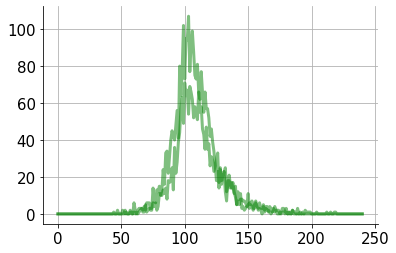

In [50]:
# Note: this is computationally expensive

# Run the model 20 times, sum over all age classes and arrondissements, show the new hospitalisations
fig,ax=plt.subplots()
for i in range(2):
    out=model.sim('21-09-2020',excess_time=50,checkpoints=chk)
    # Select this one for the sum of all NIS codes
    #sumNIS=out.sum(dim="place").sum(dim="Nc")
    # Select this one for only NIS==21000
    sumNIS=out.sel(place=21000).sum(dim='Nc')
    plt.plot(out["time"].values,sumNIS["H_in"].values,alpha=0.5,color='green')

## Visualisation on a map

### Read the arrondissements shape file

In [64]:
# Load different geographical aggregations
country = gp.read_file("../../data/raw/geopandas/BE/AD_6_Country.shp") # 1 entry
regions = gp.read_file("../../data/raw/geopandas/BE/AD_5_Region.shp") # 3 entries
provinces = gp.read_file("../../data/raw/geopandas/BE/AD_4_Province.shp") # 11 entries
arrondissements = gp.read_file("../../data/raw/geopandas/BE/AD_3_District.shp") # 43 entries
municipalities = gp.read_file("../../data/raw/geopandas/BE/AD_2_Municipality.shp") # 581 entries

municipalities

,ModifDate,City,LanguageSt,NISCode,DistrictCa,ProvinceCa,RegionCapi,CountryCap,tgid,Shape_Leng,Shape_Area,NameDut,NameFre,NameGer,geometry
0,2007-01-05,1,2,83034,1,0,0,0,{D0109DA3-34B8-46C0-92B8-BE65085732FB},85650.096718,1.220723e+08,None,Marche-en-Famenne,None,"POLYGON Z ((726984.424 600113.847 0.000, 72699..."
1,2007-01-05,1,1,23027,0,0,0,0,{2E6FAFC1-84DF-472E-AA01-3499B29786C5},45798.276630,4.498213e+07,Halle,None,None,"POLYGON Z ((643229.384 658679.116 0.000, 64323..."
2,2007-01-05,2,2,91103,0,0,0,0,{26279847-D2CA-49E1-9EAE-0D8595F62FA7},56990.073560,6.565876e+07,None,Onhaye,None,"POLYGON Z ((679740.122 601677.244 0.000, 67975..."
3,2007-01-05,1,2,91034,1,0,0,0,{CD6CED5D-6CD9-4446-B643-B8CDAABAC8BA},71326.001927,1.000560e+08,None,Dinant,None,"POLYGON Z ((692802.454 600840.203 0.000, 69279..."
4,2007-01-05,2,2,82037,0,0,0,0,{92E40A08-FC1A-44D5-94E3-D4D494FFB7C9},76994.149941,1.653600e+08,None,Gouvy,None,"POLYGON Z ((768030.137 598110.413 0.000, 76801..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,2007-01-05,2,1,23064,0,0,0,0,{E6C9ECDB-1BB4-4942-9D8F-919114BC3F62},50680.415145,3.593223e+07,Pepingen,None,None,"POLYGON Z ((636874.113 659652.145 0.000, 63686..."
577,2007-01-05,2,6,51019,0,0,0,0,{7A0BC03D-70EE-433C-96DE-DE3235252F75},27288.466641,2.328128e+07,Vloesberg,Flobecq,None,"POLYGON Z ((606791.633 658587.815 0.000, 60670..."
578,2007-01-05,2,1,23023,0,0,0,0,{A29E3DCF-FCB8-48A3-A535-1D6142B94946},34773.550910,3.529040e+07,Galmaarden,None,None,"POLYGON Z ((624454.001 657690.921 0.000, 62444..."
579,2007-01-05,2,5,23100,0,0,0,0,{9BEE1FE4-7916-47D3-BC0F-DA8CDB553779},11726.014201,4.189117e+06,Linkebeek,Linkebeek,None,"POLYGON Z ((648812.711 662598.946 0.000, 64881..."


### Perform a single simulation

#### Comments Michiel
* Again note that different simulations give *very* different results (more than order of magnitude difference)! Run code below a couple of time to see this.
* The plot below shows whether the pandemic was 'serious': it shows whether it is worth making a gif from
* In images the cumulative data is shown. In the plot below as well.
* The statement `out.sum(dim="Nc")['M'][:,day]` can be made more efficient with cumsumNIS_M (but not really necessary)
* x100 in `data2plot` because we want to show the percentage
* `norm=colors.LogNorm`: Normalize a given value to the 0-1 range on a log scale.
* I'm not sure what the difference is between the first frame and the other frames (legend on/off?)
* 

[autoreload of covid19model.models.models failed: Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 387, in update_generic
    update(a, b)
  File "C:\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 332, in update_class
    if (old_obj == new_obj) is True:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]
c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\models.py:333: RuntimeWarning: divide by zero encountered in true_divide
  (1 - np.exp(- l * m_ICU * (1/dICU_D) ))*np.ones([place.shape[0],Nc.shape[0]]),
c:\users\mrollier\documents\github\covid19-model\src

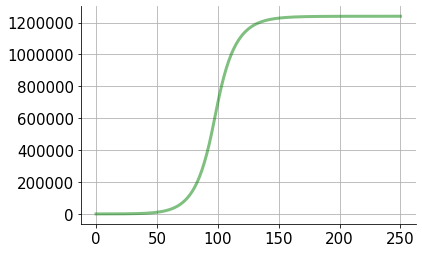

In [65]:
# simulation for 250 days (after March 15th) with the measure changes defined above
out=model.sim(250,checkpoints=chk)

# Again sum over all ages and arrondissements, and show people that are mildly affected on a national level
sumNIS=out.sum(dim="place").sum(dim="Nc")
cumsumNIS_M = np.cumsum(sumNIS["M"]) # sumNIS["M"]
plt.plot(out["time"], cumsumNIS_M, alpha=0.5, color='green')

In [131]:
output_path = 'results/maps'

# create the plot
fig, ax = plt.subplots(figsize = (12,12)) # 12 inches x 12 inches

start = 0

# Create daily images for a .gif
for day in range(start,len(out['time'].values)):
    # Get data
    # Sum over age classes (not interested in those yet) and show the percentage of mildly symptomatic people
    data2plot = out.sum(dim="Nc")['M'][:,day].values / initN_df['total'].values*100
    
    # Make new 'data' column with the cumulative mildly symptomatic people that is updated every iteration
    arrondissementen['data'] = data2plot
    
    # Visualize data
    # Only produce a legend in the first frame?
    if day == start:
        fig = arrondissementen.plot(column = 'data', ax=ax, cmap='plasma',
                                    norm=colors.LogNorm(vmin=0.001, vmax=1), legend=True, edgecolor = 'k')
    else:
        fig = arrondissementen.plot(column = 'data', ax=ax, cmap='plasma',
                                    norm=colors.LogNorm(vmin=0.001, vmax=1), legend=False, edgecolor = 'k')
    # Disable axis
    ax.set_axis_off()
    # This will save the figure as a high-res png in the output path. You can also save as svg if you prefer.
    chart = fig.get_figure()
    #chart.savefig(output_path + str(day) + '_B.jpg' ,dpi=100)
    
    plt.close()

ValueError: No match for 'arrondissement la louvière' found

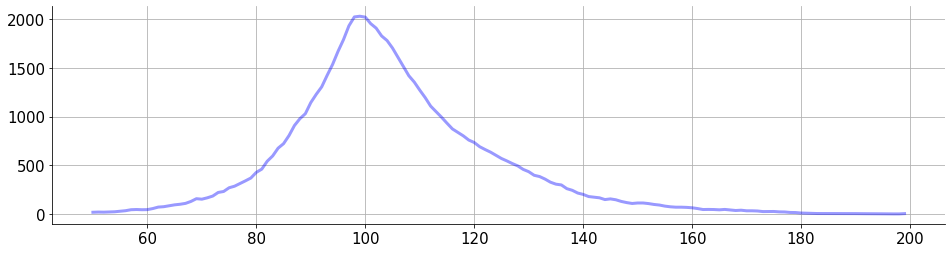

In [227]:
fig,ax=plt.subplots()
fig.set_size_inches(16, 4)
ax.plot(out['time'][50:200],out.sel(place=name2nis('arrondissement antwerpen')).sum(dim='Nc')['M'][50:200],color='blue',alpha=0.40)
ax.plot(out['time'][50:200],out.sel(place=name2nis('arrondissement La Louvière')).sum(dim='Nc')['M'][50:200],color='red',alpha=0.40)
ax.plot(out['time'][50:200],out.sel(place=name2nis('arrondissement luik')).sum(dim='Nc')['M'][50:200],color='black',alpha=0.40)
ax.legend(['Antwerp','Brussels','Luik'])
ax.axvline(130,color='black',linestyle='dashed')
ax.set_title('Daily hospitalizations $(H_{in})$')
fig.savefig('daily_hosp.jpg',dpi=300)

## Experimentations

In [19]:
# I_hg[i] = I_h[i] ( (1-p[i])*np.identity(place.shape[0]-1)[h][g] + p[i]P_hg[i] )

# T_g_eff[i] = T_h[i] * sum{h=1,G}( (1-p[i])*np.identity(place.shape[0]-1)[h][g] + p[i]P_hg[i] )

# z[i] = T[i] / sum{h=1,G}( f(rho_eff) * T_h_eff[i] )

def rho_eff(rho, xi):
    f = 1 + (1 - np.exp(-xi*rho))
    return rho
    
# rho_h_eff = sum{j=1,N}(T_h_eff[j] / a_h)

rho_eff(1, 0.01)

1.6321205588285577